## 1.0 Sonar dataset: Data quality check and EDA
---

**Purpose:** understand the data *without leakage* (EDA is run on the training split only).

**Seed:** `1206` (single source of truth to ensure reproducibility set in config.py).

In [137]:
from pathlib import Path
import sys

# Local package imports
ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT / "src"))

import numpy as np
import pandas as pd
from IPython.display import display

from submarine_threat_detection.config import DEFAULT_SEED
from submarine_threat_detection.data import load_sonar_raw, split_train_val_test

np.random.seed(DEFAULT_SEED)


### Load Data (also available at Kaggle) 

We can see from below, we are dealing with a small data set 208 rows, and 61 Columns,
with the final column index location "60" indicating our target classification:
- <span style="color:blue">Outcome="R" is Rock</span>
- <span style="color:blue">Outcome="M" is Mine</span>


In [ ]:
df = load_sonar_raw()
display(df.head())
df.shape

In [139]:

#load Sonar data set 
df_sonar = pd.read_csv(file_path, header=None)


# Data set Overview checking completness  
print("Data Overview:")
print(f"Dataset shape: {df_sonar.shape}")

target_col = 60
target_stats = {
    'Population Value Counts': df_sonar[target_col].value_counts().to_dict(),
    'Percentages': (df_sonar[target_col].value_counts(normalize=True) * 100).to_dict(),
    'Missing Values': df_sonar[target_col].isna().sum()
}

for key, value in target_stats.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            if key == 'Percentages':
                print(f"  {k}: {v:.2f}%")
            elif key == 'Proportions':
                print(f"  {k}: {v:.4f}")
            else:
                print(f"  {k}: {v}")
    else:
        print(f"  {value}")


data_quality = {
    'Total Samples': len(df_sonar),
    'Total Features': df_sonar.shape[1] - 1,  # Excluding target
    'Target Variable': 1,
    'Complete Cases': df_sonar.dropna().shape[0],
    'Complete Cases %': f"{(df_sonar.dropna().shape[0] / len(df_sonar)) * 100:.2f}%",
    'Total Missing Values': df_sonar.isna().sum().sum(),
    'Duplicated Rows': df_sonar.duplicated().sum(),
}

print("Data Quality:")
for key, value in data_quality.items():
    print(f"{key}: {value}")

Data Overview:
Dataset shape: (208, 61)

Population Value Counts:
  M: 111
  R: 97

Percentages:
  M: 53.37%
  R: 46.63%

Missing Values:
  0
Data Quality:
Total Samples: 208
Total Features: 60
Target Variable: 1
Complete Cases: 208
Complete Cases %: 100.00%
Total Missing Values: 0
Duplicated Rows: 0


### Assigning Train and Test Split

In [141]:

# Preparing Train and test data set 
X_data=df_sonar.iloc[:,:-1].values   #feature variables, everything but the last column
y_data=df_sonar.iloc[:,-1].values    #target variable, the last column coded as R/M

# encoding outcome data set to numeric M=1 and R=0 

label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)  # M=1, R=0


X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.3,random_state=42,shuffle=True,stratify=y_data)




### Exploratory data Analysis on Training data set 

The key aim is to surface structural patterns within the data, that a model may be able to exploit in low or high dimensional space to
seperate Mines from Rocks.
 
1. relatioonship between <b>features</b> and <b>target outcome</b> and validate with current understanding.
2. relationship between features, where high correlation could produce problems fo some algorithms and require attention.
3. Understand outlier prevelance and underlying distribution of features across Mines and Rocks

We have already established above that there are no missing values that will require treatment. 
     

In [143]:
# Create masks for each class
mine_mask = (y_train == 0)
rock_mask = (y_train == 1)


# Calculate KL divergence or mean difference for each feature
separation_scores = []

for col in range(X_train.shape[1]):
    mine_values = X_train[mine_mask, col]
    rock_values = X_train[rock_mask, col]
    
    # Calculate mean difference (normalized by pooled std)
    mean_diff = abs(mine_values.mean() - rock_values.mean())
    pooled_std = np.sqrt((mine_values.std()**2 + rock_values.std()**2) / 2)
    separation = mean_diff / pooled_std if pooled_std > 0 else 0
    
    separation_scores.append({
        'feature': col,
        'separation_score': separation,
        'mine_mean': mine_values.mean(),
        'rock_mean': rock_values.mean(),
        'mean_diff': mean_diff
    })

# Convert to dataframe and sort
separation_df = pd.DataFrame(separation_scores)
separation_df = separation_df.sort_values('separation_score', ascending=False)

print(f"\nTop 10 Most Separating Features:")
print(separation_df.head(10).to_string(index=False))

# Get top 10 features
top_10_features = separation_df.head(10)['feature'].values




Top 10 Most Separating Features:
 feature  separation_score  mine_mean  rock_mean  mean_diff
       0                 0        NaN        NaN        NaN
       1                 0        NaN        NaN        NaN
      32                 0        NaN        NaN        NaN
      33                 0        NaN        NaN        NaN
      34                 0        NaN        NaN        NaN
      35                 0        NaN        NaN        NaN
      36                 0        NaN        NaN        NaN
      37                 0        NaN        NaN        NaN
      38                 0        NaN        NaN        NaN
      39                 0        NaN        NaN        NaN


/var/folders/19/6kbfghdd21g845nryy206_pr0000gn/T/ipykernel_87777/4211403902.py:14: RuntimeWarning: Mean of empty slice.
  mean_diff = abs(mine_values.mean() - rock_values.mean())
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/19/6kbfghdd21g845nryy206_pr0000gn/T/ipykernel_87777/4211403902.py:21: RuntimeWarning: Mean of empty slice.
  'mi


PLOTTING FEATURE DISTRIBUTIONS


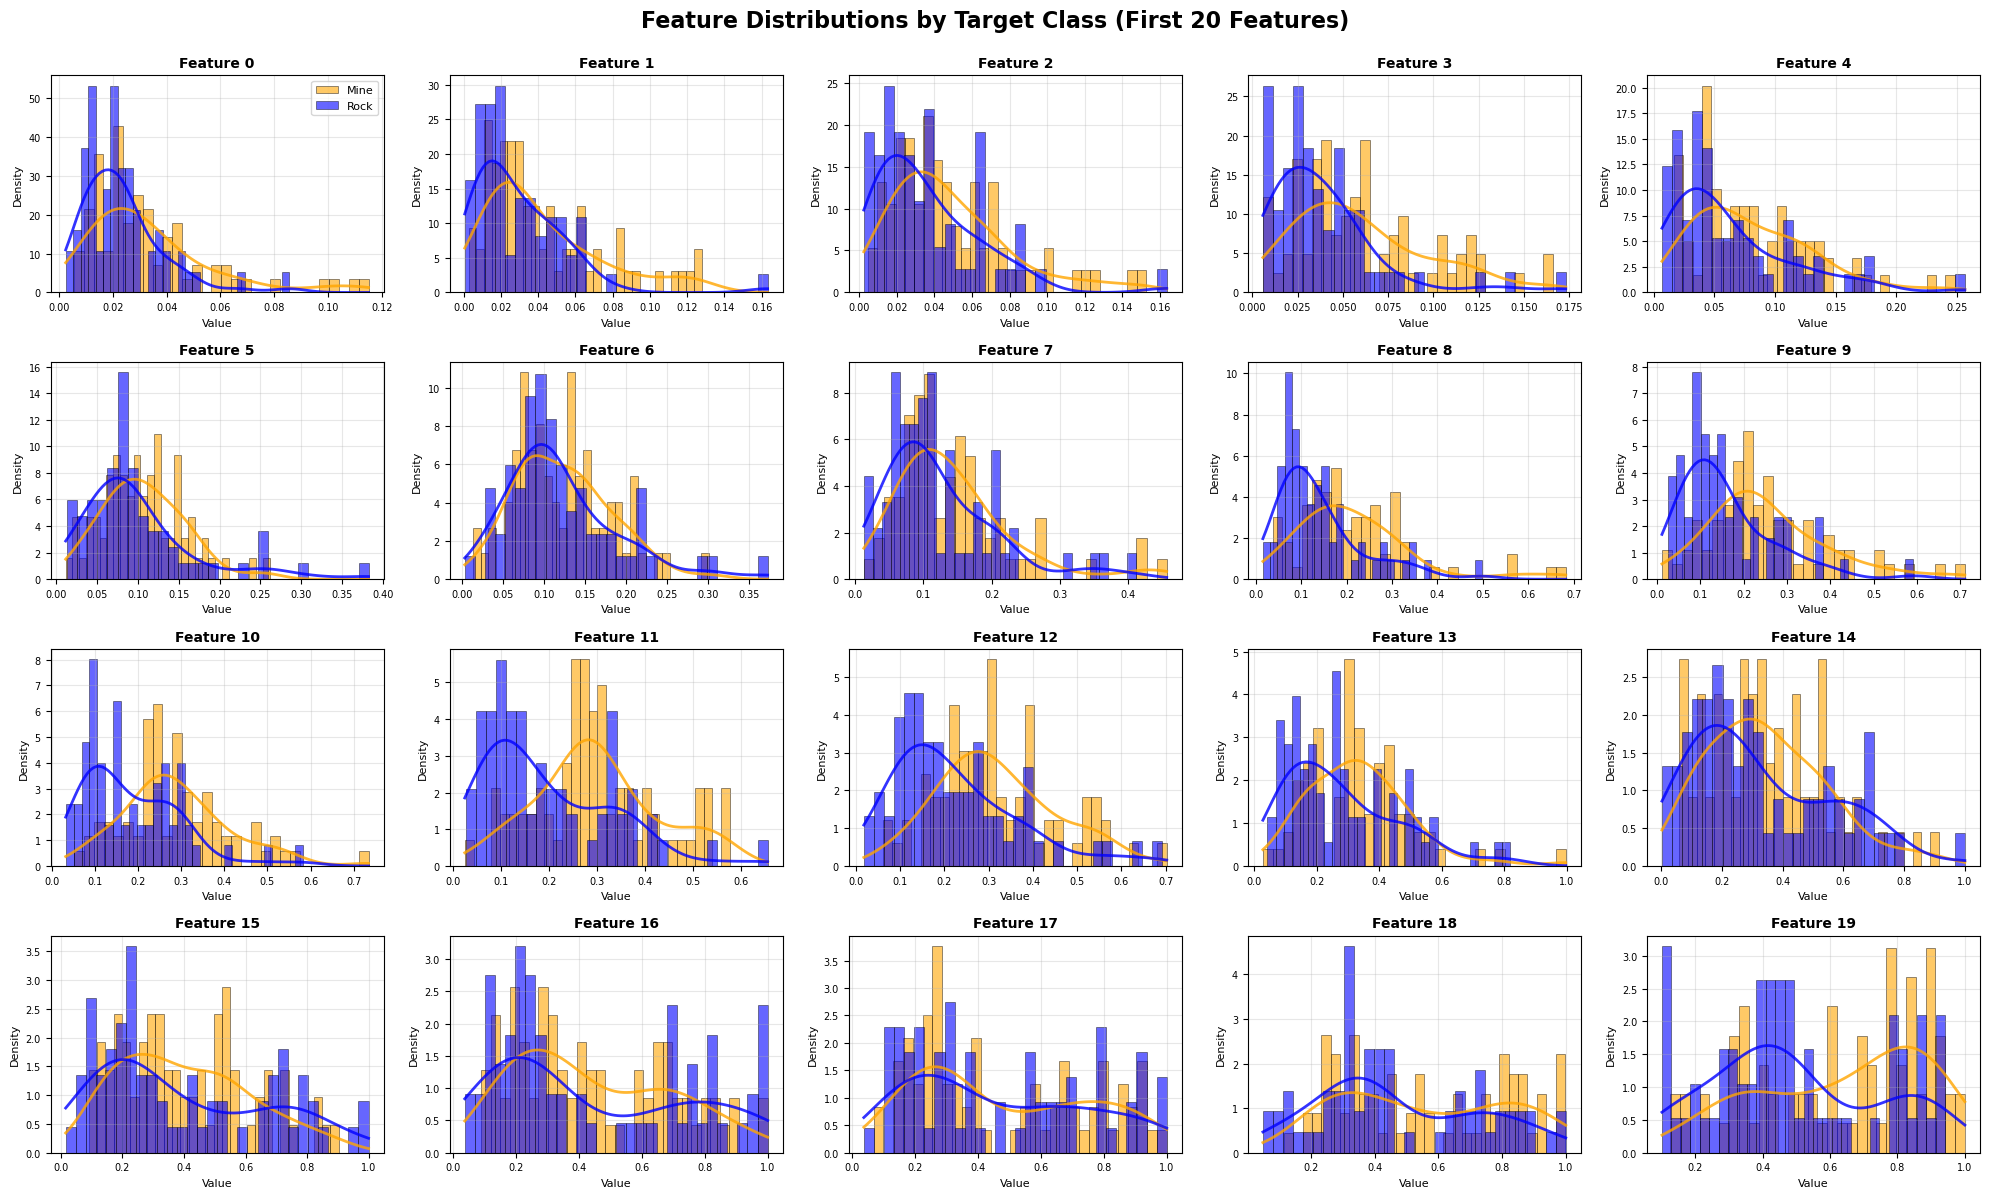

In [129]:

# PLOT FIRST 20 FEATURE distributions bu class Mine vs Rock

print("\n" + "="*70)
print("PLOTTING FEATURE DISTRIBUTIONS")
print("="*70)

# Plot first 20 features as sample (4x5 grid)
n_sample_features = 20
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
fig.suptitle('Feature Distributions by Target Class (First 20 Features)', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < n_sample_features:
        col = idx
        mine_values = X_train[mine_mask, col]
        rock_values = X_train[rock_mask, col]
        
        # Create density plots
        ax.hist(mine_values, bins=30, alpha=0.6, color='orange', 
                label='Mine', density=True, edgecolor='black', linewidth=0.5)
        ax.hist(rock_values, bins=30, alpha=0.6, color='blue', 
                label='Rock', density=True, edgecolor='black', linewidth=0.5)
        
        # Add KDE lines
        try:
            mine_kde = stats.gaussian_kde(mine_values)
            rock_kde = stats.gaussian_kde(rock_values)
            x_range = np.linspace(min(mine_values.min(), rock_values.min()),
                                 max(mine_values.max(), rock_values.max()), 100)
            ax.plot(x_range, mine_kde(x_range), 'orange', linewidth=2, alpha=0.8)
            ax.plot(x_range, rock_kde(x_range), 'blue', linewidth=2, alpha=0.8)
        except:
            pass
        
        ax.set_title(f'Feature {col}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Value', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


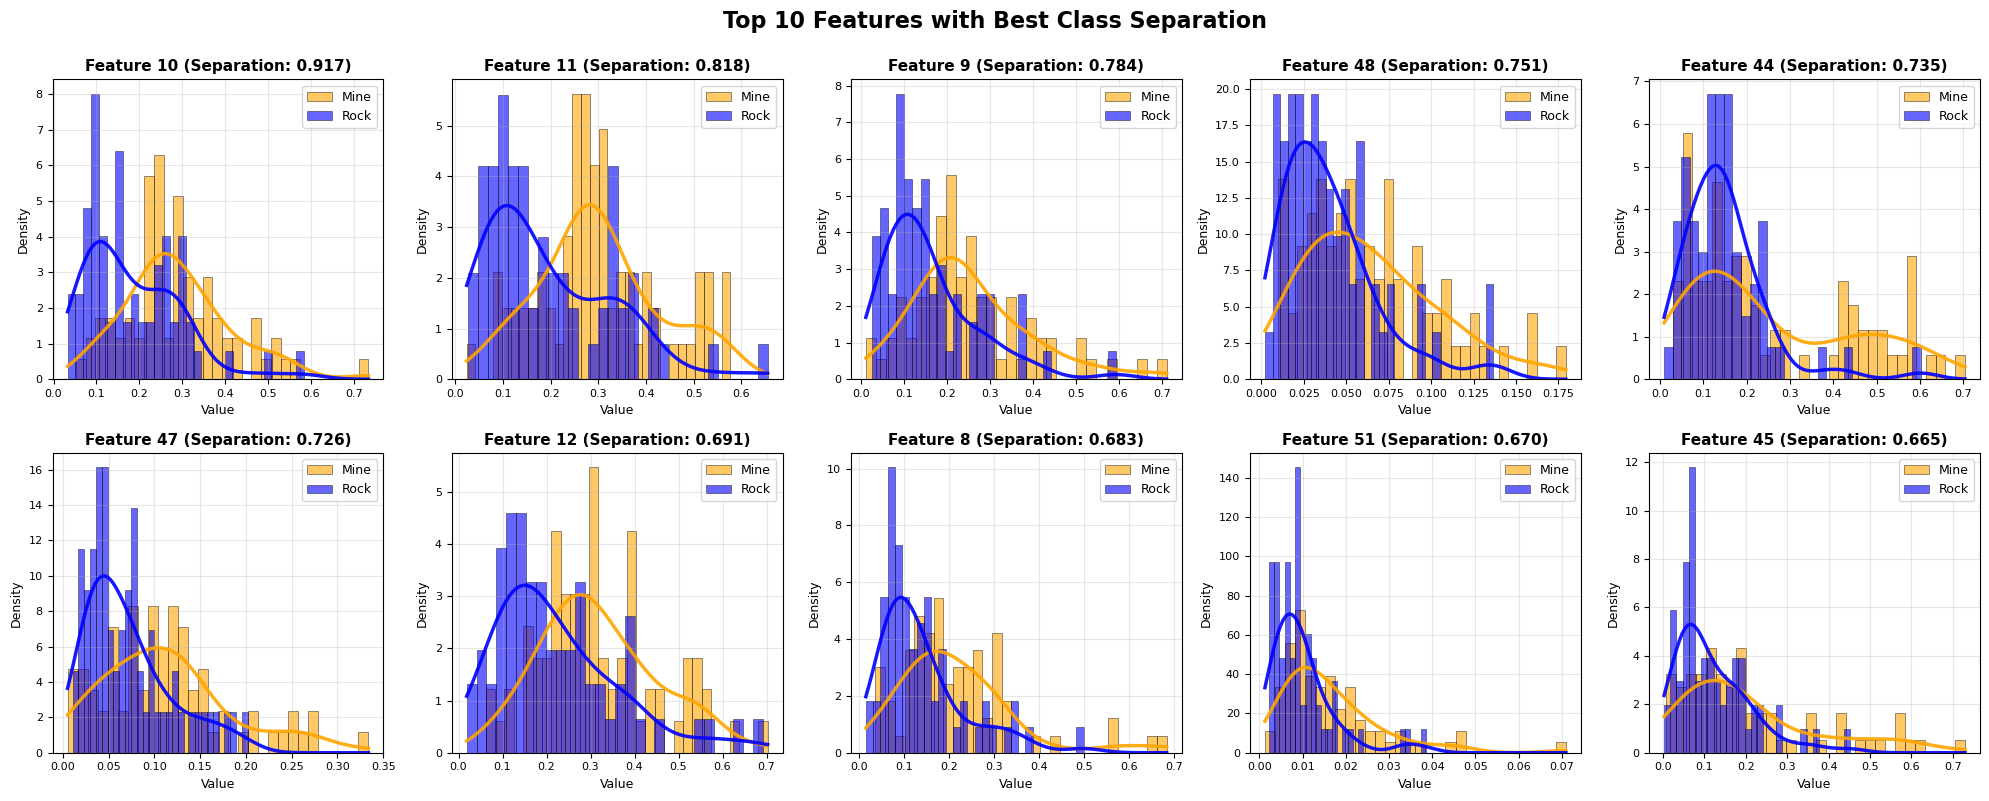

In [133]:
# 3. PLOT TOP 10 MOST SEPARATING FEATURES (2x5 grid)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Top 10 Features with Best Class Separation', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, (ax, feature_idx) in enumerate(zip(axes.flat, top_10_features)):
    mine_values = X_train[mine_mask, feature_idx]
    rock_values = X_train[rock_mask, feature_idx]
    
    # Get separation score
    sep_score = separation_df[separation_df['feature'] == feature_idx]['separation_score'].values[0]
    
    # Create density plots
    ax.hist(mine_values, bins=30, alpha=0.6, color='orange', 
            label='Mine', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(rock_values, bins=30, alpha=0.6, color='blue', 
            label='Rock', density=True, edgecolor='black', linewidth=0.5)
    
    # Add KDE lines
    try:
        mine_kde = stats.gaussian_kde(mine_values)
        rock_kde = stats.gaussian_kde(rock_values)
        x_range = np.linspace(min(mine_values.min(), rock_values.min()),
                             max(mine_values.max(), rock_values.max()), 100)
        ax.plot(x_range, mine_kde(x_range), 'orange', linewidth=2.5, alpha=0.9)
        ax.plot(x_range, rock_kde(x_range), 'blue', linewidth=2.5, alpha=0.9)
    except:
        pass
    
    ax.set_title(f'Feature {feature_idx} (Separation: {sep_score:.3f})', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

## Density plots for contious variables for each continous feature by Target variable for all features and the for the top 10 features 5 per line that show the most seperation between classess. 

###Correlation heat map plot for features 

Analyzing: Original Training Data
Shape: (145, 60)

Top 20 features by target correlation:
 feature  correlation
      10    -0.414799
      11    -0.378349
       9    -0.362150
      48    -0.347817
      44    -0.338981
      47    -0.336866
      12    -0.326357
       8    -0.319929
      51    -0.313496
      45    -0.310094
      50    -0.309187
       3    -0.304510
      46    -0.299889
      43    -0.298859
      20    -0.287508
      19    -0.276727
      53    -0.274787
      55    -0.266301
      49    -0.263621
      57    -0.261007


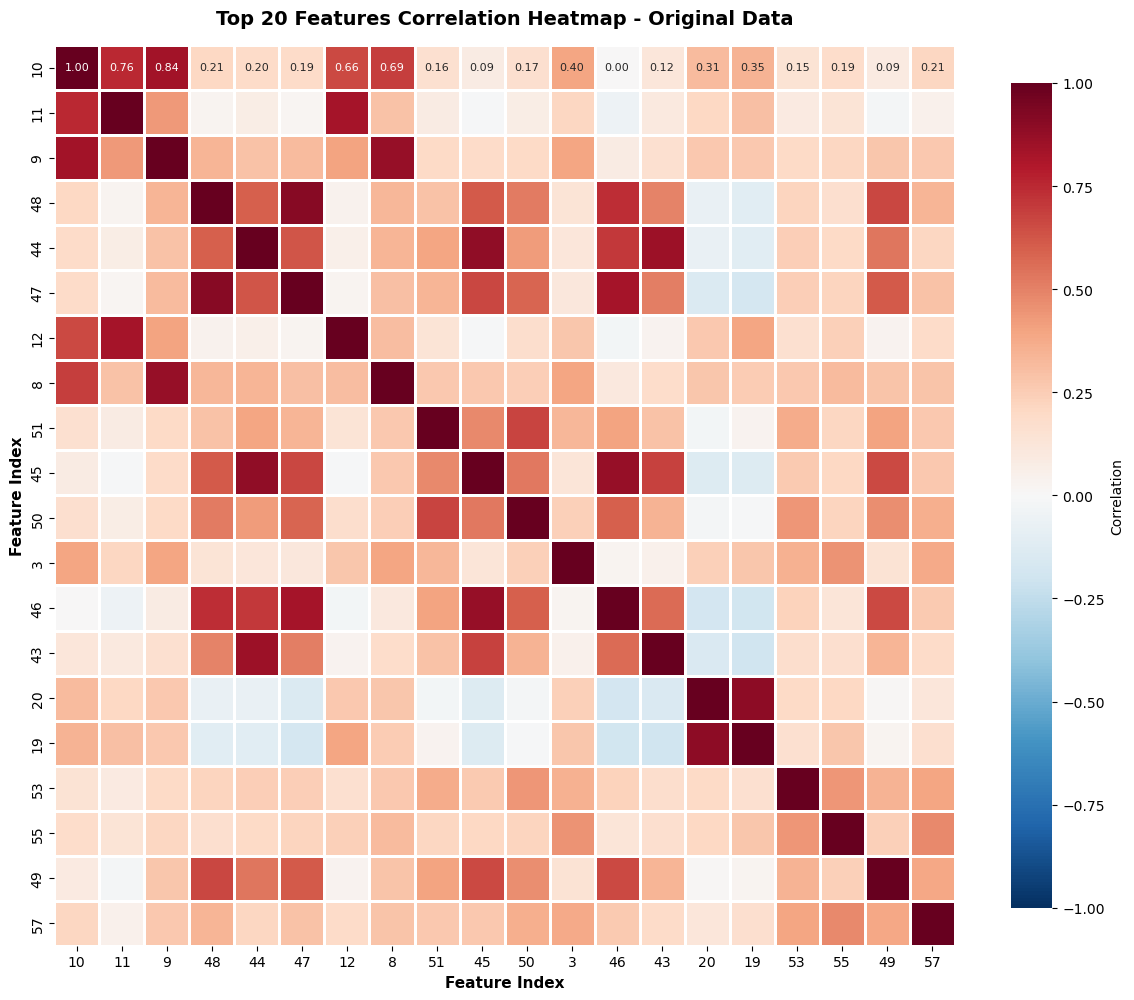

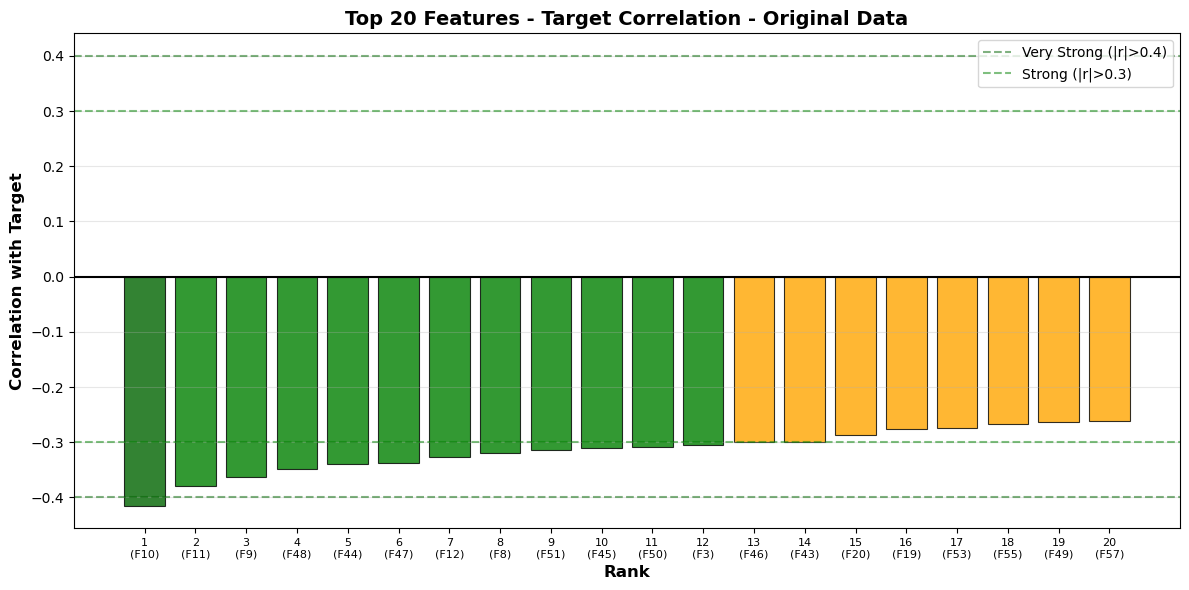


CORRELATION SUMMARY - TOP 20 FEATURES

Feature-Feature Correlations (Top 20):
  Mean: 0.276
  Max: 0.910
  High correlations (|r|>0.8): 9 pairs

Feature-Target Correlations (Top 20):
  Mean |r|: 0.315
  Max |r|: 0.415
  Range: 0.261 to 0.415



In [145]:
### Correlation Analysis - Visual Focus

### Correlation Analysis - Top 20 Features Only

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# CONFIGURATION
# ==============================================================================
USE_SCALED_DATA = False  # Toggle: True for scaled, False for original

# Select data
X_analysis = pd.DataFrame(
    X_train_scaled if USE_SCALED_DATA else X_train,
    columns=range(X_train.shape[1])
)
data_label = "Scaled" if USE_SCALED_DATA else "Original"

print(f"Analyzing: {data_label} Training Data")
print(f"Shape: {X_analysis.shape}")

# ==============================================================================
# FIND TOP 20 FEATURES BY TARGET CORRELATION
# ==============================================================================
# Calculate correlation with target (using encoded y_train)
feature_target_corr = []
for col in range(X_train.shape[1]):
    data_col = X_train_scaled[:, col] if USE_SCALED_DATA else X_train[:, col]
    corr = np.corrcoef(data_col, y_train_encoded)[0, 1]  # Use encoded target
    feature_target_corr.append({
        'feature': col,
        'correlation': corr,
        'abs_correlation': abs(corr)
    })

corr_df = pd.DataFrame(feature_target_corr)
corr_df = corr_df.sort_values('abs_correlation', ascending=False)

# Get top 20 features
top_20_features = corr_df.head(20)['feature'].values
print(f"\nTop 20 features by target correlation:")
print(corr_df.head(20)[['feature', 'correlation']].to_string(index=False))

# ==============================================================================
# 1. CORRELATION HEATMAP - TOP 20 FEATURES ONLY
# ==============================================================================
# Select top 20 features
X_top20 = X_analysis.iloc[:, top_20_features]
corr_matrix_top20 = X_top20.corr()

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    corr_matrix_top20,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation', 'shrink': 0.9},
    annot_kws={'size': 8},
    xticklabels=top_20_features,
    yticklabels=top_20_features,
    ax=ax
)

ax.set_title(f'Top 20 Features Correlation Heatmap - {data_label} Data', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Feature Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature Index', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ==============================================================================
# 2. FEATURE-TARGET CORRELATION - TOP 20 ONLY
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

top_20_corr = corr_df.head(20)

colors = ['darkgreen' if abs(c) > 0.4 else 'green' if abs(c) > 0.3 
          else 'orange' for c in top_20_corr['correlation']]

x_pos = range(20)
ax.bar(x_pos, top_20_corr['correlation'], color=colors, 
       edgecolor='black', linewidth=0.8, alpha=0.8)

# Reference lines
ax.axhline(0, color='black', linewidth=1.5)
ax.axhline(0.4, color='darkgreen', linestyle='--', alpha=0.5, label='Very Strong (|r|>0.4)')
ax.axhline(-0.4, color='darkgreen', linestyle='--', alpha=0.5)
ax.axhline(0.3, color='green', linestyle='--', alpha=0.5, label='Strong (|r|>0.3)')
ax.axhline(-0.3, color='green', linestyle='--', alpha=0.5)

ax.set_xlabel('Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Correlation with Target', fontsize=12, fontweight='bold')
ax.set_title(f'Top 20 Features - Target Correlation - {data_label} Data', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{i+1}\n(F{f})" for i, f in enumerate(top_20_corr['feature'])], 
                    fontsize=8, rotation=0)
ax.legend(loc='best')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# SUMMARY
# ==============================================================================
print("\n" + "="*70)
print("CORRELATION SUMMARY - TOP 20 FEATURES")
print("="*70)

# Feature-feature (top 20 only)
off_diag = corr_matrix_top20.values[np.triu_indices_from(corr_matrix_top20.values, k=1)]
print(f"\nFeature-Feature Correlations (Top 20):")
print(f"  Mean: {off_diag.mean():.3f}")
print(f"  Max: {off_diag.max():.3f}")
print(f"  High correlations (|r|>0.8): {(np.abs(off_diag) > 0.8).sum()} pairs")

# Feature-target (top 20)
print(f"\nFeature-Target Correlations (Top 20):")
print(f"  Mean |r|: {top_20_corr['abs_correlation'].mean():.3f}")
print(f"  Max |r|: {top_20_corr['abs_correlation'].max():.3f}")
print(f"  Range: {top_20_corr['abs_correlation'].min():.3f} to {top_20_corr['abs_correlation'].max():.3f}")

print("\n" + "="*70)

Plots to identify outliers 

spider radial plot of means b y class 

In [43]:
print(len(df_sonar.columns))
print(df_sonar.shape)
df_sonar.describe()


61
(208, 61)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900
